In [117]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from quant.Classification import Classification
from quant.factor import get_factors, get_label
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.set_printoptions(precision=4, suppress=True)

import warnings
warnings.filterwarnings('ignore')

#### Retrieve Data

We will retrieve the kline (hourly) data of BTCUSDT from locally stored data from 2020-01-01 to 2020-04-30.

In [118]:
klines_1h_file = 'data/futures_klines_1h_BTCUSDT_20200101_20220430.zip'
kline_1h_df = pd.read_csv(klines_1h_file, index_col=0, parse_dates=True)
kline_1h_df.shape

(20279, 9)

In [119]:
kline_1h_df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
datetime,,,,,,,,,
2020-01-01 00:00:00,7189.4300,7190.5200,7170.1500,7171.5500,2449.0490,17576424.4397,3688,996.1980,7149370.7635
2020-01-01 01:00:00,7171.4300,7225.0000,7171.1000,7210.2400,3865.0380,27838046.0067,6635,2340.8780,16860294.0535
2020-01-01 02:00:00,7210.3800,7239.3000,7206.4600,7237.9900,3228.3650,23324810.4072,5120,1774.1450,12818470.6412
2020-01-01 03:00:00,7237.4100,7239.7400,7215.0000,7221.6500,2513.3070,18161821.8587,4143,1245.0650,8996218.6884
2020-01-01 04:00:00,7221.8000,7225.4100,7211.2200,7213.8600,1176.6660,8493630.8678,1966,586.8640,4236084.2605
...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00,38325.2000,38488.8000,38287.0000,38447.7000,5550.1960,213006687.4170,68727,2769.8410,106289422.7287
2022-04-30 20:00:00,38447.8000,38447.8000,38257.4000,38313.4000,3983.8840,152805088.3850,52584,1789.2270,68630115.7914
2022-04-30 21:00:00,38313.4000,38360.0000,38232.1000,38284.4000,3583.9260,137252791.0508,46096,1717.0050,65758782.2231


In [120]:
kline_1h_df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,20279.0000,30794.9640,18752.3412,4062.9500,10273.2900,34959.0900,46682.5050,68714.8500
high,20279.0000,30972.4070,18859.9301,4598.0000,10314.7400,35333.0000,46946.9450,69198.7000
low,20279.0000,30608.8552,18640.4668,3621.8100,10235.7650,34623.0000,46420.8100,68525.9600
close,20279.0000,30797.0314,18752.2975,4062.8900,10273.5850,34960.0100,46683.6450,68714.8500
volume,20279.0000,13932.7239,12969.4531,63.9320,6197.1570,10006.6820,16983.6585,227392.2280
quote_asset_volume,20279.0000,447751909.8033,503151704.4331,3157740.2210,94598838.6803,310543118.3811,605852754.3196,7939435659.1860
number_of_trades,20279.0000,104426.6599,108271.2708,457.0000,31435.0000,77616.0000,137144.5000,1738439.0000
taker_buy_base_asset_volume,20279.0000,6936.8551,6456.5727,28.1000,3073.2870,5000.3420,8489.1215,108963.0120
taker_buy_quote_asset_volume,20279.0000,222467636.8032,249807148.2132,1388152.2398,47422265.9208,153884920.9467,299235376.1150,3758830164.0414


In [121]:
kline_1h_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20279 entries, 2020-01-01 00:00:00 to 2022-04-30 23:00:00
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open                          20279 non-null  float64
 1   high                          20279 non-null  float64
 2   low                           20279 non-null  float64
 3   close                         20279 non-null  float64
 4   volume                        20279 non-null  float64
 5   quote_asset_volume            20279 non-null  float64
 6   number_of_trades              20279 non-null  int64  
 7   taker_buy_base_asset_volume   20279 non-null  float64
 8   taker_buy_quote_asset_volume  20279 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.5 MB


### Factors

In [122]:
kline_1h_factors = get_factors(kline_1h_df)
kline_1h_factors

,Price,Returns,CumReturns,Log_Returns,Returns_Ratio,O-C,H-L,PR5,PR10,PR20,PR30,PR60,MOM5,MOM10,MOM20,MOM30,MOM60,SMA5,SMA10,SMA20,SMA30,SMA60,EMA,Sign
datetime,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03 13:00:00,7346.0700,0.0033,0.0243,0.0033,0.9873,-24.7600,68.1500,-0.0050,0.0041,0.0151,0.0068,-0.0020,88.0700,398.7200,379.2100,238.5100,135.8300,7332.1800,7273.3880,7112.6480,7113.7007,7156.3930,7171.4641,0
2020-01-03 14:00:00,7252.7000,-0.0127,0.0113,-0.0128,1.0087,93.0400,130.9500,-0.0247,-0.0497,-0.0131,-0.0185,-0.0166,-92.4500,48.3300,282.8500,104.1400,14.7100,7313.6900,7278.2210,7126.7905,7117.1720,7156.6382,7171.4721,1
2020-01-03 15:00:00,7316.0100,0.0087,0.0201,0.0087,1.0092,-63.2900,71.5600,0.0135,0.0072,0.0074,0.0072,0.0110,6.0100,100.4200,336.5700,156.6000,94.3600,7314.8920,7288.2630,7143.6190,7122.3920,7158.2108,7171.4864,1
2020-01-03 16:00:00,7383.0000,0.0092,0.0295,0.0091,0.9959,-67.6400,118.2200,0.0053,0.0117,0.0141,0.0094,0.0102,44.8900,186.0000,438.0500,225.1900,169.1400,7323.8700,7306.8630,7165.5215,7129.8983,7161.0298,7171.5072,0
2020-01-03 17:00:00,7352.9000,-0.0041,0.0253,-0.0041,0.9983,30.1000,67.1100,-0.0018,-0.0042,-0.0082,-0.0011,-0.0050,31.3300,154.8800,379.4000,216.6600,132.5900,7330.1360,7322.3510,7184.4915,7137.1203,7163.2397,7171.5251,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30 18:00:00,38325.1000,0.0014,4.3440,0.0014,1.0032,-53.7000,161.4000,0.0022,0.0033,0.0003,-0.0025,-0.0011,-165.3000,-236.2000,-257.0000,-563.3000,-1069.9000,38336.6600,38441.5300,38536.0850,38583.9867,39067.4467,34177.4090,1
2022-04-30 19:00:00,38447.7000,0.0032,4.3611,0.0032,0.9965,-122.5000,201.8000,0.0097,0.0021,0.0035,-0.0061,0.0040,209.4000,-156.9000,-124.5000,-802.5000,-917.3000,38378.5400,38425.8400,38529.8600,38557.2367,39052.1583,34177.8301,0
2022-04-30 20:00:00,38313.4000,-0.0035,4.3424,-0.0035,0.9992,134.4000,190.4000,-0.0088,-0.0021,-0.0047,0.0044,-0.0096,-126.5000,-238.9000,-306.3000,-626.0000,-1290.6000,38353.2400,38401.9500,38514.5450,38536.3700,39030.6483,34178.2380,0


In [123]:
kline_1h_factors.columns

Index(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'O-C',
       'H-L', 'PR5', 'PR10', 'PR20', 'PR30', 'PR60', 'MOM5', 'MOM10', 'MOM20',
       'MOM30', 'MOM60', 'SMA5', 'SMA10', 'SMA20', 'SMA30', 'SMA60', 'EMA',
       'Sign'],
      dtype='object')

<AxesSubplot:title={'center':'BTCUSDT Close Price Performance \n 2020-01-01 - 2022-04-30'}, xlabel='datetime'>

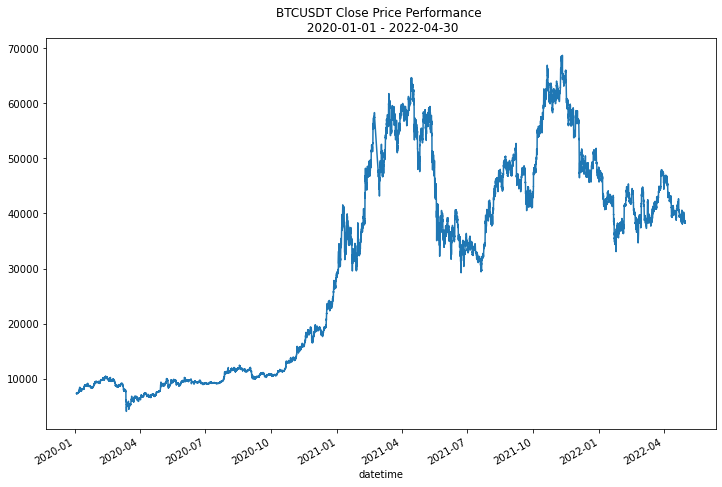

In [124]:
kline_1h_factors['Price'].plot(figsize=(12, 8), title='BTCUSDT Close Price Performance \n 2020-01-01 - 2022-04-30')

<AxesSubplot:title={'center':'BTCUSDT Returns Performance \n 2020-01-01 - 2022-04-30'}, xlabel='datetime'>

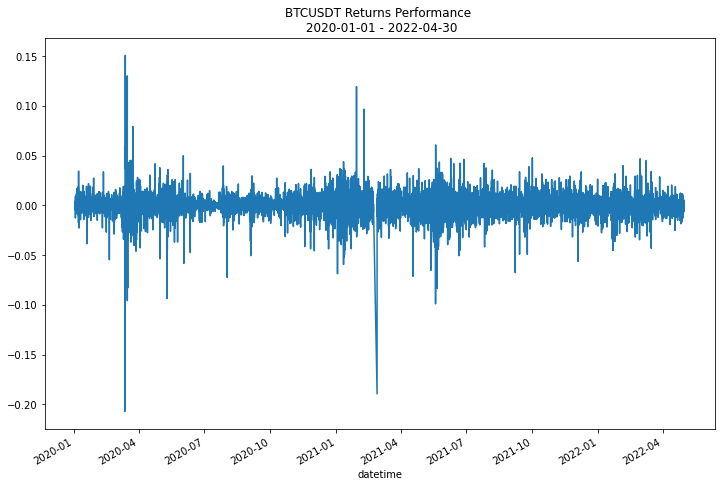

In [125]:
kline_1h_factors['Log_Returns'].plot(figsize=(12, 8), title='BTCUSDT Returns Performance \n 2020-01-01 - 2022-04-30')

<AxesSubplot:title={'center':'BTCUSDT Cumlated Returns Performance \n 2020-01-01 - 2022-04-30'}, xlabel='datetime'>

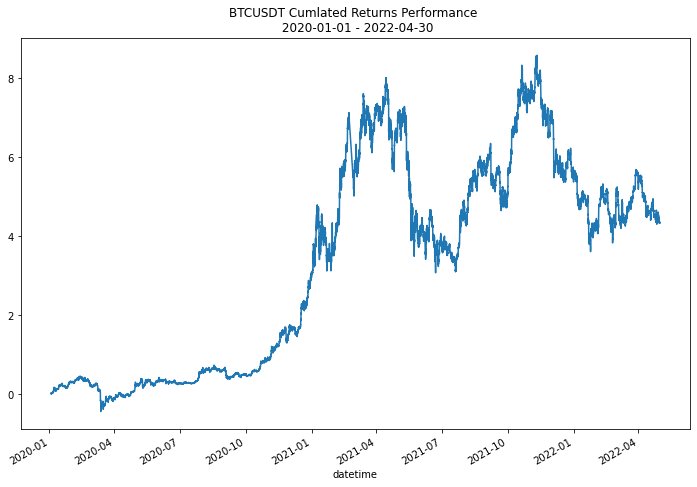

In [126]:
kline_1h_factors['CumReturns'].plot(figsize=(12, 8), title='BTCUSDT Cumlated Returns Performance \n 2020-01-01 - 2022-04-30')

In [127]:
X = kline_1h_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'Sign'], axis=1)
y = kline_1h_factors['Sign']
X.shape, y.shape

((20217, 18), (20217,))

Text(0.5, 1.0, 'Factors Correlation')

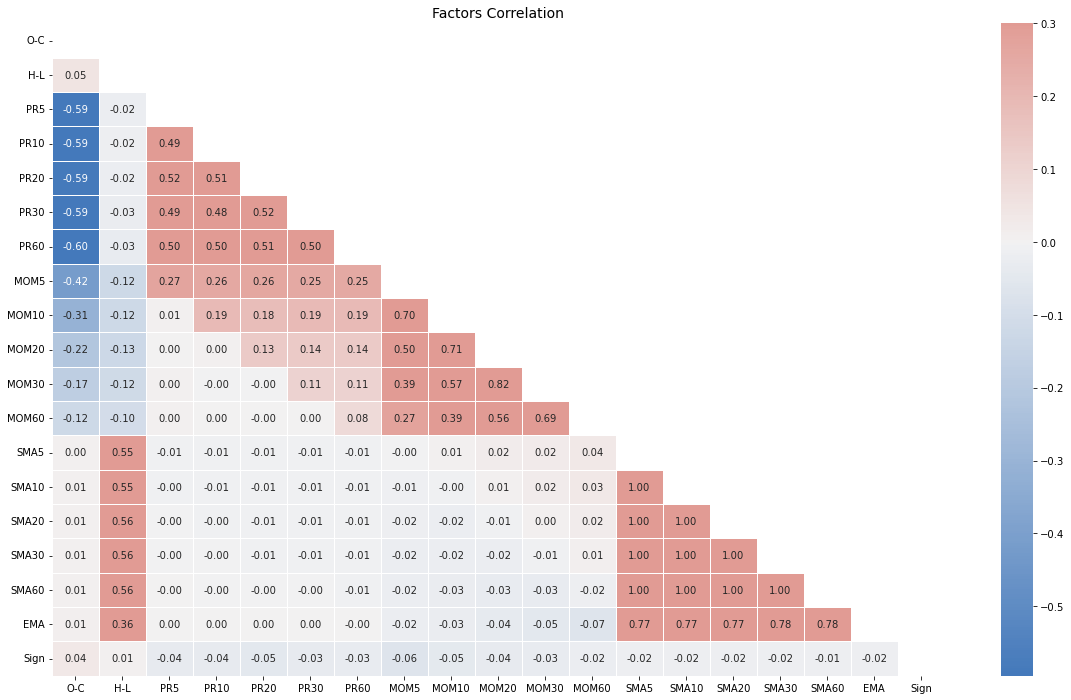

In [128]:
corr = kline_1h_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio'], axis=1).corr()

fig, ax = plt.subplots(figsize=(20, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(250, 15, as_cmap=True)

sns.heatmap(corr,
            annot=True,
            annot_kws={"size": 10},
            fmt="0.2f",
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=False,
            linewidths=.5,
            cbar_kws={"shrink": 1})

ax.set_title('Factors Correlation', fontsize=14, color='black')

### PCA

In [129]:
pca = PCA(n_components='mle', svd_solver="full")
pca.fit(X)
print(pca.explained_variance_ratio_)

pca = PCA(n_components=8, svd_solver="full")
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)


[0.9735 0.0204 0.0044 0.0009 0.0004 0.0002 0.0001 0.0001 0.     0.
 0.     0.     0.     0.     0.     0.     0.    ]
[0.9735 0.0204 0.0044 0.0009 0.0004 0.0002 0.0001 0.0001]


In [130]:
# Factors Score
decision_tree = Classification(X, y)
decision_tree.fit_predict(MinMaxScaler(), DecisionTreeClassifier(random_state=64))
decision_tree_mse, decision_tree_rmse, decision_tree_r2train, decision_tree_r2test = decision_tree.eval_metrics()
decision_tree_mse, decision_tree_rmse, decision_tree_r2train, decision_tree_r2test

(0.49455984174085066, 0.7032494875510757, 1.0, 0.5054401582591493)

In [131]:
# PCA Score
decision_tree_pca = Classification(X_pca, y)
decision_tree_pca.fit_predict(MinMaxScaler(), DecisionTreeClassifier(random_state=64))
decision_tree_pca_mse, decision_tree_pca_rmse, decision_tree_pca_r2train, decision_tree_pca_r2test = decision_tree_pca.eval_metrics()
decision_tree_pca_mse, decision_tree_pca_rmse, decision_tree_pca_r2train, decision_tree_pca_r2test

(0.4950544015825915, 0.703601024432591, 1.0, 0.5049455984174085)

In [132]:
# Result
pca_result = pd.DataFrame()
pca_result = pca_result.append([['Original Factors', decision_tree_mse, decision_tree_rmse, decision_tree_r2train, decision_tree_r2test]])
pca_result = pca_result.append([['PCA Factors', decision_tree_pca_mse, decision_tree_pca_rmse, decision_tree_pca_r2train, decision_tree_pca_r2test]])
pca_result.columns = ['', 'MSE', 'RMSE', 'R2Train', 'R2Test']
pca_result.reset_index(drop=True, inplace=True)
print(pca_result.to_latex(index=False))
pca_result

\begin{tabular}{lrrrr}
\toprule
                 &    MSE &   RMSE &  R2Train &  R2Test \\
\midrule
Original Factors & 0.4946 & 0.7032 &   1.0000 &  0.5054 \\
     PCA Factors & 0.4951 & 0.7036 &   1.0000 &  0.5049 \\
\bottomrule
\end{tabular}



,,MSE,RMSE,R2Train,R2Test
0,Original Factors,0.4946,0.7032,1.0000,0.5054
1,PCA Factors,0.4951,0.7036,1.0000,0.5049


#### Consolution

The original 18 factors were reduced to 8 factors by PCA. Comparing the score of original factors with PCA factors, we found that MSE decreased from 0.2663 to 0.2656, and R2Test decresed from 0.7337 to 0.7344. Considering the reduced amount of data and computation, the results are acceptable with less MSE and R2 Score.